In [1]:
from herbert_emotion_classifier.dataset import EmotionsInTextDataset 

from herbert_emotion_classifier.seq_model import HerbertEmotionSequenceClassifier
from herbert_emotion_classifier.datamodule import EmotionsInTextDatamodule

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from os.path import join

import pandas as pd

In [2]:
model = HerbertEmotionSequenceClassifier()
model

HerbertEmotionSequenceClassifier(
  (rnn): GRU(768, 256, num_layers=2, batch_first=True, dropout=0.3)
  (criterion): CrossEntropyLoss()
  (classifier): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=9, bias=True)
  )
)

In [3]:
train_ds = EmotionsInTextDataset(join("..", "data", "embeddings", "wust-train-embeddigs.pickle"))
val_ds = EmotionsInTextDataset(join("..", "data", "embeddings", "wust-test-embeddigs.pickle"))

In [4]:
dm = EmotionsInTextDatamodule(16, train_ds, val_ds)

In [5]:
batch = next(iter(dm.train_dataloader()))

In [6]:
batch_sentence_embedding = batch.get("sentence_embedding")
batch_sentence_embedding.size()

torch.Size([16, 768])

In [7]:
logger = WandbLogger(name="GRU2",project="TEST")

seed_everything(42)

trainer = Trainer(max_epochs=100,
                  gpus=1,
                  deterministic=True,
                  accumulate_grad_batches=2,
                  checkpoint_callback=False,
                  callbacks=[EarlyStopping(monitor='val/loss', patience=5)],
                  logger=logger
                  )

trainer.fit(model, dm)

model = model.eval()
# model.freeze()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: tugot17 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name       | Type             | Params
------------------------------------------------
0 | rnn        | GRU              | 1 M   
1 | criterion  | CrossEntropyLoss | 0     
2 | classifier | Sequential       | 41 K  


In [8]:
from herbert_emotion_classifier.predict import predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [9]:
import torch

@torch.no_grad()
def predict(model, dataloader, device, get_x_method):
    """
    :param model:
    :param dataloader:
    :param device:
    :param get_x_method:
    :return:
    """
    model = model.to(device)

    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)

    batch_size = dataloader.batch_size

    predictions = torch.zeros(num_elements, 9)
    true_labels = torch.zeros(num_elements)

    for i, batch in enumerate(dataloader):
        start = i * batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements

        x = get_x_method(batch)
        y = batch["label"]

        # case for rgb infrared as two seprete inputs
        if isinstance(x, tuple):
            x = (element.to(device) for element in x)
        else:
            x = x.to(device)

        logits = model(x)
        predictions[start:end] = logits.detach().cpu()
        true_labels[start:end] = y.cpu()
    
    return predictions, true_labels

In [10]:
model = model.eval()

predictions, true_labels = predict(model, dm.val_dataloader(), "cuda", lambda batch: batch["seq_embedding"])

In [11]:
predictions.size()

torch.Size([1264, 9])

In [12]:
class_names = ['oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc', 'neutralne']

<AxesSubplot:>

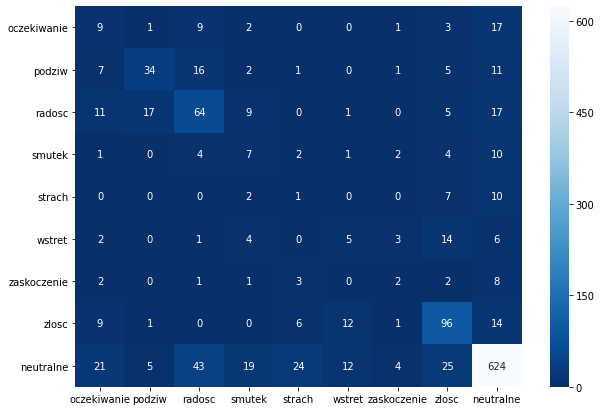

In [13]:
cm = confusion_matrix(true_labels, predictions.argmax(1))
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, fmt="d")

In [14]:
print(classification_report(true_labels, predictions.argmax(1), target_names=class_names))

              precision    recall  f1-score   support

 oczekiwanie       0.15      0.21      0.17        42
      podziw       0.59      0.44      0.50        77
      radosc       0.46      0.52      0.49       124
      smutek       0.15      0.23      0.18        31
      strach       0.03      0.05      0.04        20
      wstret       0.16      0.14      0.15        35
 zaskoczenie       0.14      0.11      0.12        19
       zlosc       0.60      0.69      0.64       139
   neutralne       0.87      0.80      0.84       777

   micro avg       0.67      0.67      0.67      1264
   macro avg       0.35      0.35      0.35      1264
weighted avg       0.70      0.67      0.68      1264



In [15]:
predictions.size()

torch.Size([1264, 9])

In [16]:
import numpy as np

n=2

topn = torch.argsort(predictions, axis = 1)[:,-n:]
topn

tensor([[0, 8],
        [0, 8],
        [2, 1],
        ...,
        [0, 8],
        [0, 7],
        [0, 8]])

In [17]:
in_top_k = torch.tensor([1 if true_labels[k] in topn[k] else 0 for k in range(len(topn))])

In [18]:
torch.mean(in_top_k.float())

tensor(0.7903)

In [19]:
in_top_k
real = torch.ones_like(in_top_k)

In [20]:
model = model.eval().cpu()

PATH= "wust_seq_model.pth"

torch.save(model.state_dict(), PATH)

In [22]:
new_model = HerbertEmotionSequenceClassifier()
new_model.load_state_dict(torch.load(PATH), strict=False)
new_model = new_model.eval()